# Integrazione numerica dell'equazione della vorticità barotropica

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm

In [17]:
### Setting dei parametri ###

DAYLEN  = 7   #  Forecast length in days.
DtHours = .5   #  Timestep in hours.
cmap='jet'

### Definizione delle funzioni ###  

def make_Laplacian(Z):
    #  Compute the Laplacian 
    # of the geopotential height
    # within the boundary
    # (boundary excluded)
    M       = Z.shape[0]
    N       = Z.shape[1]
    Zxx  = np.zeros([M,N])     #  second x derivative of Z
    Zyy  = np.zeros([M,N])     #  second y derivative of Z
    L0in     = np.zeros([M-1,N-1])     #  Laplacian of Z
    # Compute within the domain (no boundaries) 
    # Second x-derivative of Z
    Zxx[1:M-1,:] = (Z[2:M,:]+Z[0:M-2,:]-2*Z[1:M-1,:])/(736e+3**2)
    # Second y-derivative of Z
    Zyy[:,1:N-1] = (Z[:,2:N]+Z[:,0:N-2]-2*Z[:,1:N-1])/(736e+3**2)    
    ##  Laplacian of height (or vorticity)
    L0in = Zxx[1:M-1,1:N-1]+Zyy[1:M-1,1:N-1]
    return L0in

def make_Jacobian(Z,ABS_VOR):
    M       = Z.shape[0]
    N       = Z.shape[1]
    Zx    = np.zeros([M,N])     #  x derivative of Z
    Zy    = np.zeros([M,N])     #  y derivative of Z
    ABS_VORx  = np.zeros([M,N])     #  x derivative of ABS_VOR
    ABS_VORy  = np.zeros([M,N])     #  y derivative of ABS_VOR
    # Compute within 
    #the domain (boundary excluded) 
    # x-derivative of Z
    Zx[1:M-1,:] = (Z[2:M,:]-Z[0:M-2,:])/(2*736e+3)
    # y-derivative of Z
    Zy[:,1:N-1] = (Z[:,2:N]-Z[:,0:N-2])/(2*736e+3)
    # x-derivative of the absolute vorticity 
    ABS_VORx[1:M-1,:] = (ABS_VOR[2:M,:]-ABS_VOR[0:M-2,:])/(2*736e+3)
    # y-derivative of the absolute vorticity 
    ABS_VORy[:,1:N-1] = (ABS_VOR[:,2:N]-ABS_VOR[:,0:N-2])/(2*736e+3)
    ##  Compute the Jacobian J(ABS_VOR,Z)
    Jacobi = ABS_VORx * Zy - ABS_VORy * Zx
    return Jacobi

def Poisson_solver(Jacobi):
    M       = Jacobi.shape[0]
    N       = Jacobi.shape[1]
    SM=np.zeros([M-2,M-2])
    SN=np.zeros([N-2,N-2])
    EIGEN=np.zeros([M-2,N-2])    
    ##  Coefficients for x-transformation
    for m1 in range(0,M-2):
     for m2 in range(0,M-2):
      SM[m1,m2] = np.sin(np.pi*(m1+1)*(m2+1)/(M-1))       
    ##  Coefficients for y-transformation
    for n1 in range(0,N-2):
     for n2 in range(0,N-2):
      SN[n1,n2] = np.sin(np.pi*(n1+1)*(n2+1)/(N-1))        
    ##  Eigenvalues of Laplacian operator
    for mm in range(0,M-2):
     for nn in range(0,N-2):
      eigen = (np.sin(np.pi*(mm+1)/(2*(M-1))))**2 +(np.sin(np.pi*(nn+1)/(2*(N-1))))**2
      EIGEN[mm,nn] = (-4/736e+3**2) * eigen
    #  Tendency values in interior.
    Ldot = Jacobi[1:M-1,1:N-1] 
    #  Compute the transform of the solution
    LDOT = np.dot(SM,np.dot(Ldot,SN))
    #  Convert transform of d(xi)/dt to transform of d(Z)/dt
    ZDOT = LDOT / EIGEN 
    #  Compute inverse transform to get the height tendency.
    Zdot = (4/((M-1)*(N-1))) *np.dot(SM,np.dot(ZDOT,SN))
    return Zdot
      
 
def make_f_and_h(N,M,Xp,Yp):
    FCOR=np.zeros([M,N])
    h=np.zeros([M,N])    
    a = (4*10**7)/(2*np.pi)      #  Radius of the Earth
    grav = 9.80665           #  Gravitational acceleration
    Omega = 2*np.pi/(24*60*60)  #  Angular velocity of Earth.
    ##  Compute Coriolis Parameter and Map Factor
    ##  and parameter h = g*m**2/f used in the BVE
    for ny in range(0,N):
     for nx in range(0,M):
      xx = (nx-Xp)*736e+3
      yy = (ny-Yp)*736e+3
      rr = np.sqrt(xx**2+yy**2)
      phi = 2*((np.pi/4)-np.arctan(rr/(2*a)))
      mapPS = 2 / (1+np.sin(phi))
      f = 2*Omega*np.sin(phi)
      FCOR[nx,ny] = f
      h[nx,ny] = grav * mapPS**2 / f
    return FCOR,h

### Parametri fissati ###

M  = 19 # Points in x direction
N  = 16 # Points in y direction
Xp = 8 # Coord. of North Pole
Yp = 12 # Coord. of North Pole


### Coordinate e tempo ###

daylen = DAYLEN                   #  Integration time (in days)
seclen = int(daylen*24*60*60)     #  Integration time (in secon736e+3)
Dt = DtHours*60*60                #  Timestep in secon736e+3
nt = int(seclen//Dt )             #  Total number of time-steps.
# Define the (X,Y) grid (for plotting)
X, Y  = np.meshgrid(np.linspace(1,M,M),np.linspace(1,N,N))
X = np.transpose(X)
Y = np.transpose(Y)
#Coriolis and map factor
FCOR,h=make_f_and_h(N,M,Xp,Yp)


### Definizione degli array ###

ddtZ    = np.zeros([M,N])     #  Tendency of Z
Zout=np.zeros([nt+1,M,N])   
L0=np.zeros([nt+1,M,N])


### Lettura dei dati di input e verifica ###
###   Read and plot the initial and verification height data
## Input files
File1 = 'Case1-1949010503.z00'
File2 = 'Case1-1949010603.z00'
Z0  = np.genfromtxt(File1, dtype=None)
Z24 = np.genfromtxt(File2, dtype=None)

In [18]:
### INTEGRAZIONE ###

# Copia del campo iniziale
Zout[:,:,:]  = Z0[:,:]     

#Calcolo delle funzioni per t=0
L0[0, 1:M-1, 1:N-1] = make_Laplacian(Z0)

#Fare il Laplaciano all'istante di tempo t=0, senza le bc
#Qui aggiungiamo le bc
L0[:, 0, :] = 2*L0[0, 1, :] - L0[0, 2, :]
L0[:, M-1, :] = 2*L0[0, M-2, :] - L0[0, M-3, :]
L0[:, :, 0] = 2*L0[0,:,1]-L0[0,:,2]
L0[:, :, N-1] = 2*L0[0,:,N-2]-L0[0,:,N-3]

#Ora calcoliamo J0
J=np.zeros([nt+1,M,N])
J[0, :, :] = make_Jacobian(Z0, h*L0[0, :, :]+FCOR)

#Si calcola la derivata
ddtZ = Poisson_solver(J[0, :, :])

#Questa matrice è tale che la cornice è costante e ad ogni time step è costante
Zout[1, 1:M-1, 1:N-1] = Zout[0, 1:M-1, 1:N-1] + Dt*ddtZ

for i in range(1,nt):
    L0[i, 1:M-1, 1:N-1] = make_Laplacian(Zout[i, :, :])
    J[i, :, :] = make_Jacobian(Zout[i, :, :], h*L0[i, :, :]+FCOR)
    ddtZ= Poisson_solver(J[i, :, :])
    Zout[i+1, 1:M-1, 1:N-1] = Zout[i-1, 1:M-1, 1:N-1 ] + ddtZ*Dt*2
   

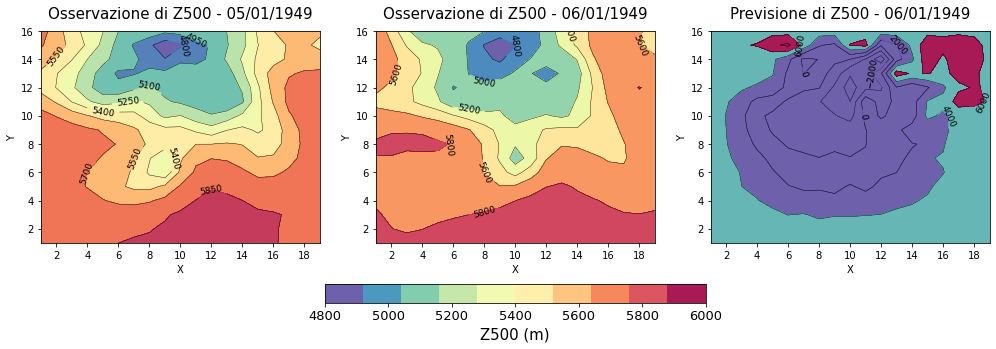

In [19]:
fig, ax = plt.subplots(figsize = [17,5], nrows = 1, ncols = 3)

Z0 = Zout[0, :, :]
zout = Zout[-1, :, :]

norm = Normalize(vmin = 4800, vmax = 6000)


ax[0].contourf(X, Y, Z0, norm=norm, cmap='Spectral_r', alpha = .9)
ax[0].set_title("Osservazione di Z500 - 05/01/1949", fontsize = 15, y=1.03)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')

cs = ax[0].contour(X, Y, Z0, colors="black", linewidths = .4)
ax[0].clabel(cs, inline=1, fontsize=9, colors = 'black')


ax[1].contourf(X, Y, Z24, norm=norm, cmap='Spectral_r', alpha = .9)
ax[1].set_title("Osservazione di Z500 - 06/01/1949", fontsize = 15, y=1.03)
cs = ax[1].contour(X, Y, Z24, colors="black", linewidths = .4)
ax[1].clabel(cs, inline=1, fontsize=9, colors = 'black')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')

ax[2].contourf(X, Y, zout, norm=norm, cmap='Spectral_r', alpha = .9)
ax[2].set_title("Previsione di Z500 - 06/01/1949", fontsize = 15, y=1.03)
cs = ax[2].contour(X, Y, zout, colors="black", linewidths = .4)
ax[2].clabel(cs, inline=1, fontsize=9, colors = 'black')
#ax[2].contour(X, Y, Z24, colors = "black", linewidths = .6, linestyles = "dashed")
ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')


cbar = fig.colorbar(mappable = ScalarMappable(norm = norm, cmap = plt.get_cmap("Spectral_r", 10)), 
    orientation = "horizontal",
    alpha = .9, ax = ax[0:3], location = "bottom", fraction = 0.07)

cbar.ax.tick_params(labelsize = 13)
cbar.set_label(label = "Z500 (m)", fontsize = 15)
#fig.subplots_adjust(hspace = 0.2)

plt.savefig("campiZ.pdf", bbox_inches = "tight")

C:\Users\feder\AppData\Local\Temp\ipykernel_15772\1730476941.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(X, Y, Z0, colors = "black", label = "z0", linewidths = .4, levels = 10)


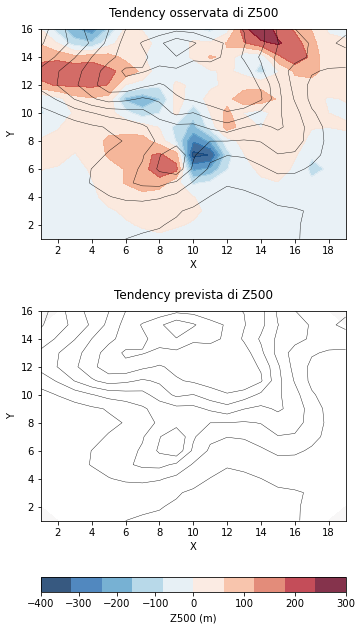

In [10]:
fore_diff = zout - Z0
true_diff = Z24 - Z0

fig, ax = plt.subplots(figsize = [5,10], nrows = 2, ncols = 1)

norm = TwoSlopeNorm(vmin = -400, vmax = 300, vcenter = 0)

ax[0].contourf(X, Y, true_diff, norm = norm, cmap = "RdBu_r", alpha = .8, levels = 10)
ax[0].contour(X, Y, Z0, colors = "black", linewidths = .4, levels = 10)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
#ax[0].contour(X, Y, Z24, colors = "red", linestyles = "dashed")

ax[0].set_title("Tendency osservata di Z500", y=1.03)

ax[1].contourf(X, Y, fore_diff, norm = norm, cmap = "RdBu_r", alpha = .8, levels = 10)
ax[1].contour(X, Y, Z0, colors = "black", label = "z0", linewidths = .4, levels = 10)
#ax[1].contour(X, Y, zout, colors = "red", linestyles = "dashed")
ax[1].set_title("Tendency prevista di Z500", y=1.03)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')

fig.tight_layout(h_pad=4)
fig.colorbar(mappable = ScalarMappable(norm = norm, cmap = plt.get_cmap("RdBu_r", 10)), 
    orientation = "horizontal", label = "Z500 (m)",
    alpha = .8, ax = ax[0:2], location = "bottom")

fig.subplots_adjust(bottom = 0.27)

plt.savefig("tendency.pdf", bbox_inches = "tight")

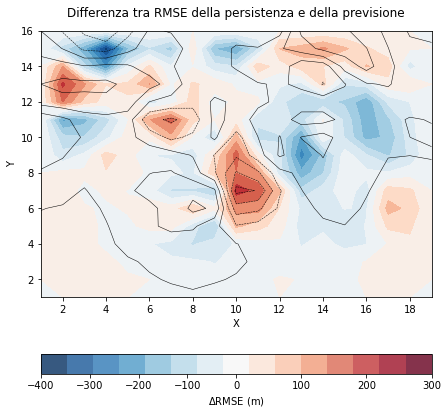

In [240]:
fore_RMSE = np.abs(zout - Z24)
pers_RMSE = np.abs(Z0 - Z24)

fig, ax = plt.subplots(figsize = [7,7], nrows = 1, ncols = 1)

norm2 = TwoSlopeNorm(vmin = -400,vcenter=0, vmax =300)

e = ax.contourf(X, Y, pers_RMSE - fore_RMSE, cmap='RdBu_r', levels = 15, norm=norm2)
ax.set_title('Differenza tra RMSE della persistenza e della previsione', y=1.03)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.contour(X, Y, true_diff, colors='black', linewidths = .5)
fig.colorbar(mappable = ScalarMappable(norm=norm2, cmap=plt.get_cmap('RdBu_r', 15)),
    orientation = "horizontal", label = "$\Delta$RMSE (m)",
    alpha = .8, ax = ax, location = "bottom")

plt.savefig("RMSE_diffs.pdf", bbox_inches = "tight")

In [241]:
print("zout RMSE:", fore_RMSE.mean())
print("pers RMSE:", pers_RMSE.mean())

zout RMSE: 74.41585571107608
pers RMSE: 61.10744868421052


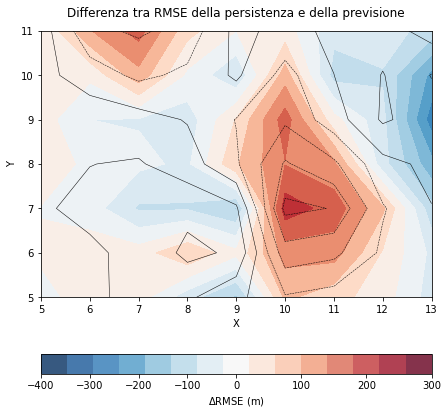

In [242]:
fig, ax = plt.subplots(figsize = [7,7], nrows = 1, ncols = 1)

norm2 = TwoSlopeNorm(vmin = -400, vcenter=0, vmax =300)

ax.contourf(X[4:13, 4:11], Y[4:13, 4:11], pers_RMSE[4:13,4:11] - fore_RMSE[4:13,4:11], cmap='RdBu_r', levels = 15, norm=norm2)
ax.set_title('Differenza tra RMSE della persistenza e della previsione', y=1.03)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.contour(X[4:13, 4:11], Y[4:13, 4:11], true_diff[4:13,4:11], colors='black', linewidths = .5)
fig.colorbar(mappable = ScalarMappable(norm=norm2, cmap=plt.get_cmap('RdBu_r', 15)),
    orientation = "horizontal", label = "$\Delta$RMSE (m)",
    alpha = .8, ax = ax, location = "bottom")

plt.savefig("RMSE_ciclo.pdf", bbox_inches = "tight")

In [243]:
print("zout RMSE:", fore_RMSE[4:13, 4:11].mean())
print("persistency RMSE:", true_RMSE[4:13, 4:11].mean())


zout RMSE: 101.66553202523583
persistency RMSE: 103.50493492063488


## Media di ensemble

In [244]:
# Inizializzazione della lista di ensembles
Z_list = []
Z0_plist = []

num = 50 # numero di membri dell'ensemble
for i in range(num):
    
    ddtZ    = np.zeros([M,N])     #  Tendency of Z
    Zout=np.zeros([nt+1,M,N])   
    L0=np.zeros([nt+1,M,N])
    # Perturbiamo la condizione iniziale
    
    Z0_p = Z0 + np.random.random()*400 - 200
    Z0_plist.append(Z0_p)
    
    Zout[:,:,:]  = Z0_p[:,:]      #  Copy initial height field

    #Calcolo delle funzioni per t=0
    L0[0, 1:M-1, 1:N-1] = make_Laplacian(Z0_p)
    #Fare il Laplaciano all'istante di tempo t=0, senza le bc
    #Qui aggiungiamo le bc
    L0[:, 0, :] = 2*L0[0, 1, :] - L0[0, 2, :]
    L0[:, M-1, :] = 2*L0[0, M-2, :] - L0[0, M-3, :]
    L0[:, :, 0] = 2*L0[0,:,1]-L0[0,:,2]
    L0[:, :, N-1] = 2*L0[0,:,N-2]-L0[0,:,N-3]

    #Ora calcoliamo J0
    J=np.zeros([nt+1,M,N])
    J[0, :, :] = make_Jacobian(Z0, h*L0[0, :, :]+FCOR)

    #Si calcola la derivata
    ddtZ = Poisson_solver(J[0, :, :])
    #Questa matrice è tale che la cornice è costante e ad ogni time step è costante

    Zout[1, 1:M-1, 1:N-1] = Zout[0, 1:M-1, 1:N-1] + Dt*ddtZ

    for i in range(1,nt):
        L0[i, 1:M-1, 1:N-1] = make_Laplacian(Zout[i, :, :])
        J[i, :, :] = make_Jacobian(Zout[i, :, :], h*L0[i, :, :]+FCOR)
        ddtZ= Poisson_solver(J[i, :, :])
        Zout[i+1, 1:M-1, 1:N-1] = Zout[i-1, 1:M-1, 1:N-1 ] + ddtZ*Dt*2
   
    Z_list.append(Zout[-1, : , :])

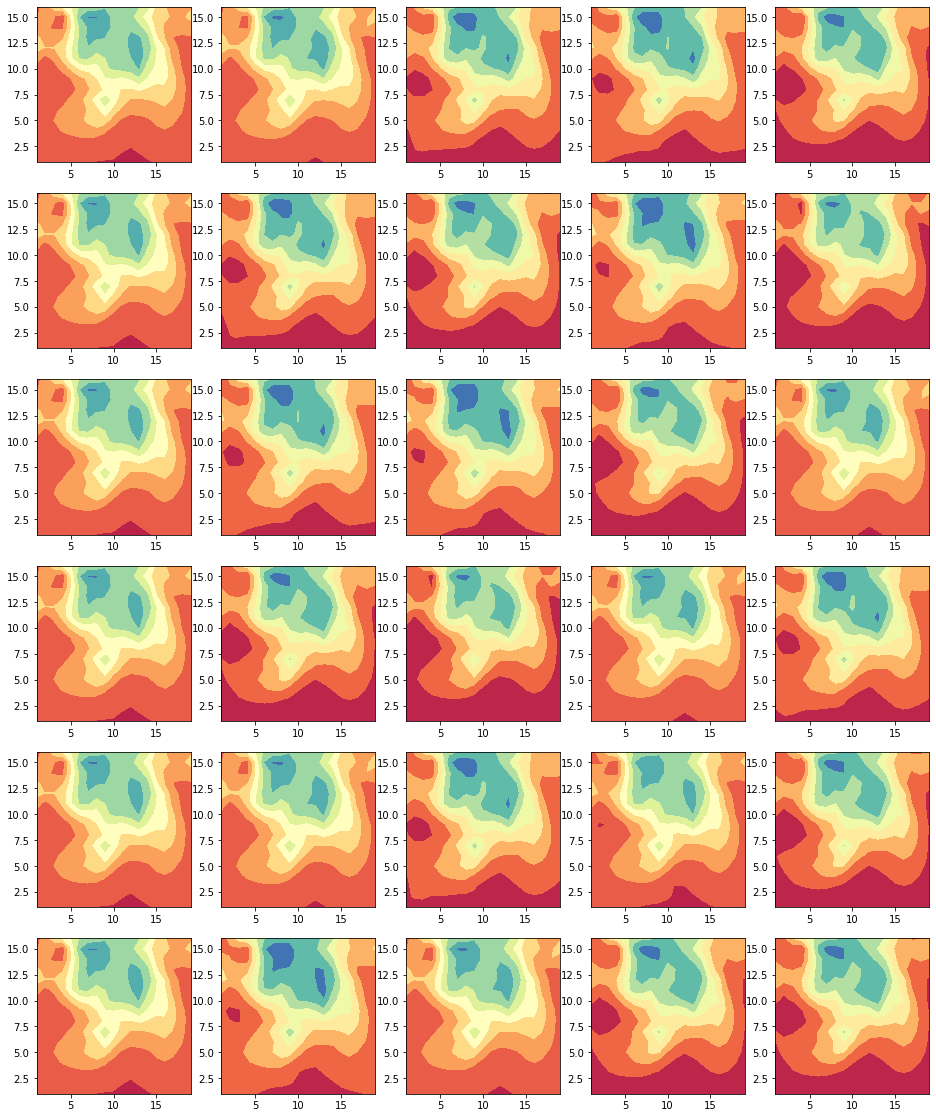

In [245]:
fig, axs = plt.subplots(figsize = [16,20], nrows = 6, ncols = 5)

cx = 0
for i in range(6):
    cx += 1 
    for j in range(5):
        axs[i,j].contourf(X, Y, Z_list[cx*j], cmap = "Spectral_r")
        
plt.savefig("ensembles.png", bbox_inches = "tight")

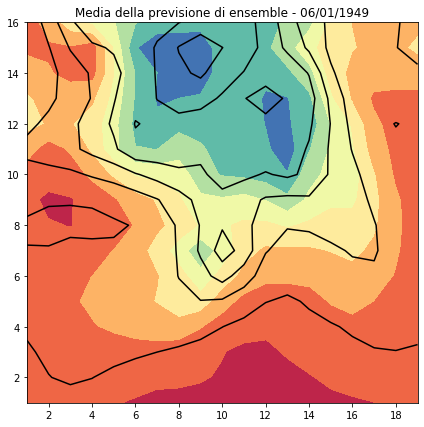

In [246]:
Z_mean = np.mean(Z_list, axis = 0)

fig = plt.figure(figsize = [7,7])

plt.title("Media della previsione di ensemble - 06/01/1949")
plt.contourf(X, Y, Z_mean, cmap = "Spectral_r")
plt.contour(X, Y, Z24, colors = "black")

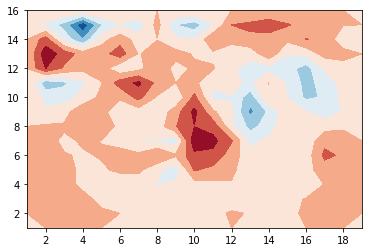

In [247]:
ens_RMSE = np.abs(Z_mean - Z24)
fore_RMSE = np.abs(zout - Z24)

diff = true_RMSE - fore_RMSE

fig = plt.figure()
plt.contourf(X, Y, diff, cmap = "RdBu_r")

In [248]:
200*100/4000

5.0

In [216]:
print("zout RMSE:", fore_RMSE.mean())
print("ens RMSE:", ens_RMSE.mean())

zout RMSE: 74.41585571107608
ens RMSE: 73.9814548674904


In [233]:
num_list = [10, 20, 30, 50, 100]

RMSE_list = []
for num in num_list:    
    # Inizializzazione della lista di ensembles
    Z_list = []
    Z0_plist = []

    num = 50 # numero di membri dell'ensemble
    for i in range(num):

        ddtZ    = np.zeros([M,N])     #  Tendency of Z
        Zout=np.zeros([nt+1,M,N])   
        L0=np.zeros([nt+1,M,N])
        # Perturbiamo la condizione iniziale

        Z0_p = Z0 + np.random.random()*400 - 200
        Z0_plist.append(Z0_p)

        Zout[:,:,:]  = Z0_p[:,:]      #  Copy initial height field

        #Calcolo delle funzioni per t=0
        L0[0, 1:M-1, 1:N-1] = make_Laplacian(Z0_p)
        #Fare il Laplaciano all'istante di tempo t=0, senza le bc
        #Qui aggiungiamo le bc
        L0[:, 0, :] = 2*L0[0, 1, :] - L0[0, 2, :]
        L0[:, M-1, :] = 2*L0[0, M-2, :] - L0[0, M-3, :]
        L0[:, :, 0] = 2*L0[0,:,1]-L0[0,:,2]
        L0[:, :, N-1] = 2*L0[0,:,N-2]-L0[0,:,N-3]

        #Ora calcoliamo J0
        J=np.zeros([nt+1,M,N])
        J[0, :, :] = make_Jacobian(Z0, h*L0[0, :, :]+FCOR)

        #Si calcola la derivata
        ddtZ = Poisson_solver(J[0, :, :])
        #Questa matrice è tale che la cornice è costante e ad ogni time step è costante

        Zout[1, 1:M-1, 1:N-1] = Zout[0, 1:M-1, 1:N-1] + Dt*ddtZ

        for i in range(1,nt):
            L0[i, 1:M-1, 1:N-1] = make_Laplacian(Zout[i, :, :])
            J[i, :, :] = make_Jacobian(Zout[i, :, :], h*L0[i, :, :]+FCOR)
            ddtZ= Poisson_solver(J[i, :, :])
            Zout[i+1, 1:M-1, 1:N-1] = Zout[i-1, 1:M-1, 1:N-1 ] + ddtZ*Dt*2

        Z_list.append(Zout[-1, : , :])
    
    RMSE_list.append(np.abs(np.mean(Z_list, axis = 0) - Z24).mean())

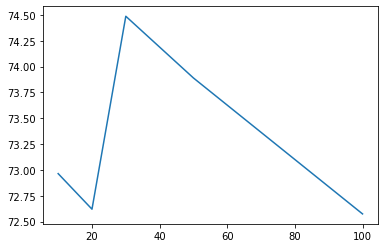

In [234]:
plt.plot(num_list, RMSE_list)

## Cambiare le condizioni istante per istante?

In [230]:
### Definizione degli array ###

ddtZ    = np.zeros([M,N])     #  Tendency of Z
Zout=np.zeros([nt+1,M,N])   
L0=np.zeros([nt+1,M,N])


File1 = 'Case1-1949010503.z00'
File2 = 'Case1-1949010603.z00'
Z0  = np.genfromtxt(File1, dtype=None)
Z24 = np.genfromtxt(File2, dtype=None)

# Copia del campo iniziale
Zout[:,:,:]  = Z0[:,:]     

#Calcolo delle funzioni per t=0
L0[0, 1:M-1, 1:N-1] = make_Laplacian(Z0)

#Fare il Laplaciano all'istante di tempo t=0, senza le bc

#Qui aggiungiamo le bc
"""
L0[0, 0, :] = 2*L0[0, 1, :] - L0[0, 2, :]
L0[0, M-1, :] = 2*L0[0, M-2, :] - L0[0, M-3, :]
L0[0, :, 0] = 2*L0[0,:,1]-L0[0,:,2]
L0[0, :, N-1] = 2*L0[0,:,N-2]-L0[0,:,N-3]
"""
L0[:, 0, :] = 2*L0[0, 1, :] - L0[0, 2, :]
L0[:, M-1, :] = 2*L0[0, M-2, :] - L0[0, M-3, :]
L0[:, :, 0] = 2*L0[0,:,1]-L0[0,:,2]
L0[:, :, N-1] = 2*L0[0,:,N-2]-L0[0,:,N-3]
    

#Ora calcoliamo J0
J=np.zeros([nt+1,M,N])
J[0, :, :] = make_Jacobian(Z0, h*L0[0, :, :]+FCOR)

#Si calcola la derivata
ddtZ = Poisson_solver(J[0, :, :])

#Questa matrice è tale che la cornice è costante e ad ogni time step è costante
Zout[1, 1:M-1, 1:N-1] = Zout[0, 1:M-1, 1:N-1] + Dt*ddtZ

for i in range(1,nt):
    L0[i, 1:M-1, 1:N-1] = make_Laplacian(Zout[i, :, :])
    
    L0[i, 0, :] = 2*L0[i, 1, :] - L0[i, 2, :]
    L0[i, M-1, :] = 2*L0[i, M-2, :] - L0[i, M-3, :]
    L0[i, :, 0] = 2*L0[i,:,1] - L0[i,:,2]
    L0[i, :, N-1] = 2*L0[i,:,N-2] - L0[i,:,N-3]

    J[i, :, :] = make_Jacobian(Zout[i, :, :], h*L0[i, :, :]+FCOR)
    ddtZ= Poisson_solver(J[i, :, :])
    Zout[i+1, 1:M-1, 1:N-1] = Zout[i-1, 1:M-1, 1:N-1 ] + ddtZ*Dt*2
   

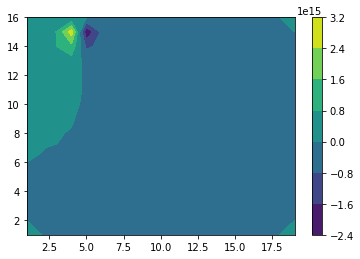

In [231]:
plt.contourf(X, Y, Zout[-1, :, :])

plt.colorbar()

## Eulero backward?